# 0) Work Directory and setup

In [29]:
import os
# Obtiene el nuevo directorio actual después del cambio
new_directory = '/Users/jyoung/Doctorado/embryo_classification/'
os.chdir(new_directory)
print("New actual directory:", new_directory)

# Elimino warnings molestas
import warnings
warnings.filterwarnings("ignore")


New actual directory: /Users/jyoung/Doctorado/embryo_classification/


# 1) Libraries

In [12]:
# Data Manipulation and Visualization
import numpy as np                  # NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt     # Matplotlib for creating visualizations
from pathlib import Path            # Pathlib for working with file paths
import openpyxl                     # Openpyxl for reading and writing Excel files
import json                         # JSON for data serialization
from tqdm import tqdm               # tqdm for creating progress bars
from typing import Tuple, List, Union  # Typing for type hinting in function signatures

# Model Training and Evaluation
import torch
import torch.nn.functional as F  # useful stateless functions
import torchvision.transforms as T
from torch.utils.data import Dataset
import torch.nn as nn

# Image Processing and Feature Extraction
from skimage import exposure         # Image exposure adjustment
from scipy import ndimage            # Multi-dimensional image processing
import skimage.measure              # Image measurement and analysis
from tensorflow.keras.preprocessing.image import img_to_array, load_img  # Image preprocessing using Keras

# Signal Processing
from scipy.signal import find_peaks, savgol_filter  # Signal processing functions in SciPy
import cv2

# 2) Functions

## Image functions

In [101]:
def load_image(region: str, index: int) -> np.ndarray:
    """
    Loads and preprocesses an image from a specified region and index.

    Parameters:
    - region (str): Name of the region.
    - index (int): Index of the image.

    Returns:
    - chosen_region (np.ndarray): Preprocessed image.
    """
    chosen_region = img_to_array(load_img(str(region) + '/' + str(index) + '.bmp', grayscale=True)).squeeze() / 255.0
    return chosen_region

def plot_sample_image(index, dataset):

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 2))

    for i in range(3):
        imagen, label = dataset.__getitem__(index)
        imagen = np.swapaxes(imagen, 0, 2)
        label = convert_to_text(label)
        axes[i].imshow(imagen)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

## Training functions

In [5]:
def apply_PCA(X, n_components):
    """
    Applies Principal Component Analysis (PCA) to the input data.

    Parameters:
    - X (array-like): Input data.
    - n_components (int): Number of components to keep.

    Returns:
    - X_pca (array-like): Transformed data after PCA.
    """
    # Apply PCA to the training set
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    # Get the variance explained by each principal component
    explained_variance_ratio = pca.explained_variance_ratio_

    cumulative_variance = np.cumsum(explained_variance_ratio)

    # Create the plot of cumulative variance
    plt.plot(range(1, n_components + 1), cumulative_variance, marker='o', linestyle='-', color='b')
    plt.title('Cumulative Variance of Principal Components')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Variance')
    plt.grid(True)
    plt.show()
    
    return X_pca

def accuracy(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

def train(model, optimizer, epochs=1):
    model = model.to(device=device)
    for t, (x, y) in enumerate(tqdm(loader_train)):
        model.train() 
        x = x.to(device=device, dtype=dtype) 
        y = y.to(device=device, dtype=torch.long)
        scores = model(x)
        loss = F.cross_entropy(scores, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()




## New training functions

In [ ]:
from tqdm import tqdm
import torch
import torch.nn.functional as F
from torch.cuda.amp import autocast

def train_one_epoch(model, optimizer, data_loader, device, dtype=torch.float32, scaler=None):
    model.train()
    total_loss = 0.0
    correct = 0
    total_samples = 0

    for x, y in tqdm(data_loader):
        x, y = x.to(device=device, dtype=dtype), y.to(device=device, dtype=torch.long)

        optimizer.zero_grad()

        with autocast(enabled=(scaler is not None)):
            scores = model(x)
            loss = F.cross_entropy(scores, y)

        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * x.size(0)
        _, predicted = scores.max(1)
        correct += (predicted == y).sum().item()
        total_samples += x.size(0)

    return total_loss / total_samples, correct / total_samples

def train(model, optimizer, train_loader, device, epochs=1, dtype=torch.float32, scaler=None):
    model = model.to(device=device)

    for epoch in range(epochs):
        train_loss, train_accuracy = train_one_epoch(model, optimizer, train_loader, device, dtype, scaler)

        print(f"Epoch [{epoch + 1}/{epochs}] - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")


def accuracy(loader, model, device, dtype=torch.float32):
    print(f'Checking accuracy on {"validation" if loader.dataset.train else "test"} set')

    model.eval()
    num_correct = 0
    num_samples = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device=device, dtype=dtype), y.to(device=device, dtype=torch.long)

            scores = model(x)
            _, preds = scores.max(1)
            
            num_correct += (preds == y).sum().item()
            num_samples += preds.size(0)
        
        accuracy = num_correct / num_samples if num_samples > 0 else 0
        print(f'Got {num_correct} / {num_samples} correct ({100 * accuracy:.2f}%)')
    
    return accuracy


## Dataset functions

In [95]:
class EmbryoDataset(Dataset):
    def __init__(self, img_dir, labels):
        self.img_labels = labels
        self.img_dir = img_dir
        self.transform = T.Compose([
            T.Pad(100, padding_mode='reflect'),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomRotation(degrees=(-10, 10), fill=100),
            T.Resize((400, 400)),  # Ajustamos el redimensionamiento para un valor más cercano a 300x300
            T.CenterCrop(300),  # Aplicamos un recorte al tamaño final deseado
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, str(idx + 1) + '.BMP')
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir a RGB
        label = int(self.img_labels[idx])

        if self.transform:
            image = Image.fromarray(image)
            image = self.transform(image)

        return image, label


## Utility functions

In [100]:
def convert_to_number(x):
    """
    Converts a label to its corresponding numeric value.

    Parameters:
    - x (str): Input label.

    Returns:
    - int: Numeric value corresponding to the input label.
    """
    if x == 'A':
        return 0
    if x == 'B':
        return 1
    if x == 'C':
        return 2
    
def convert_to_text(numeric_value):
    """
    Converts a numeric value to its corresponding label.

    Parameters:
    - numeric_value (int): Input numeric value.

    Returns:
    - str: Label corresponding to the input numeric value.
    """
    if numeric_value == 0:
        return 'A'
    if numeric_value == 1:
        return 'B'
    if numeric_value == 2:
        return 'C'

    
def choose_region(zone, n_data, blast_quality):
  y_ICM = np.zeros(n_data-1)
  y_TE = np.zeros(n_data-1)
  y_ZP = np.zeros(n_data-1)

  for i in np.arange(1,n_data):
    y_ICM[i-1] = convert_to_number(blast_quality[i-1][1])
    y_TE[i-1] = convert_to_number(blast_quality[i-1][2])
    y_ZP[i-1] = convert_to_number(blast_quality[i-1][0])

  if zone == 'ICM':
    y_data = y_ICM
  if zone == 'TE':
    y_data = y_TE
  if zone == 'ZP':
    y_data = y_ZP

  return y_data
    

def get_best_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu") 
    return device

best_device = get_best_device()
print("Best device available:", best_device)

Best device available: cpu


# 3) Load dataset

## Load labels

In [102]:
n_data = 250
region = 'ICM'
xlsx_file = Path('data/BlastsOnline', 'MasterlistAug30-2017.xlsx')
wb_obj = openpyxl.load_workbook(xlsx_file) 

sheet = wb_obj.active

blast_quality = []
for i in range(2,n_data+1):
    blast_quality.append(list(sheet['B'+str(i)].value))

y = choose_region(region, n_data, blast_quality)

## Build dataset

In [103]:
img_dir = 'data/BlastsOnline/Images'

EmbryoDatasetICM = EmbryoDataset(img_dir, y)

# 3) Print samples

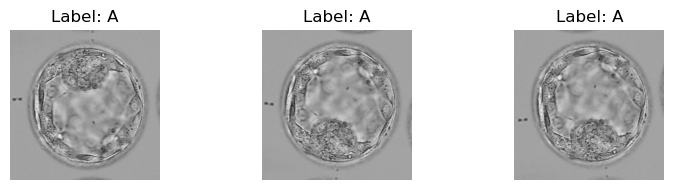

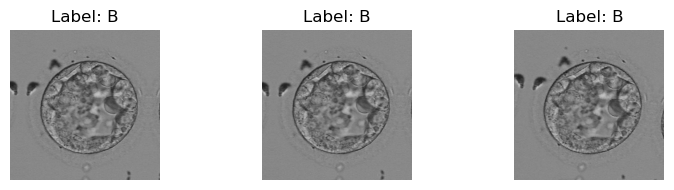

In [104]:
plot_sample_image(5, EmbryoDatasetICM)
plot_sample_image(3, EmbryoDatasetICM)

# 6) Entrenamiento

## Principal component analysis

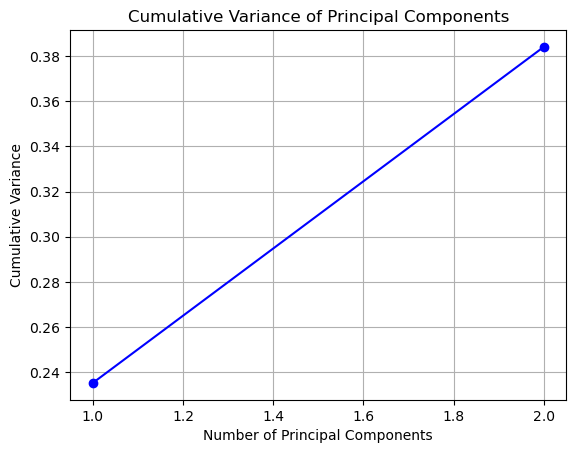

In [11]:
X_pca = apply_PCA(X, 2)

## Decision Tree

In [12]:
# Definir un espacio de búsqueda más amplio para la búsqueda de cuadrícula
param_grid = {
    'max_depth': [None, 3, 5, 8, 10],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None]
}

param_grid = {
    'max_depth': [None, 3, 5, 8, 10],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 8, 12],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_leaf_nodes': [None, 10, 20, 30],
    'min_impurity_decrease': [0.0, 0.1, 0.2, 0.3],
    'class_weight': [None, 'balanced']
}


clf = DecisionTreeClassifier(class_weight='balanced', random_state=42)

output = run_halving_grid_search(X, y, clf, param_grid)

output = run_halving_grid_search(X_pca, y, clf, param_grid)

## Random Forest

In [ ]:
clf = RandomForestClassifier(class_weight='balanced', random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_samples': [None, 0.8, 0.9, 1.0],  # Solo para bootstrap=True
    'oob_score': [True, False],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

output = run_halving_grid_search(X, y, clf, param_grid)

output = run_halving_grid_search(X_pca, y, clf, param_grid)

0it [00:00, ?it/s]


Best parameters: {'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}

Mean Accuracy in cross-validation: 0.619241103848947
Standard Deviation of Accuracy in cross-validation: 0.06364876631487318


0it [00:00, ?it/s]

Best parameters: {'bootstrap': True, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

Mean Accuracy in cross-validation: 0.6792588053740014
Standard Deviation of Accuracy in cross-validation: 0.06977601295264185


## SVM

In [ ]:
clf = SVC(class_weight='balanced', random_state=42)

# Definir el espacio de búsqueda
param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 1e-3, 1e-4],
    'degree': [2, 3, 4],  # Solo para kernel 'poly'
    'coef0': [0.0, 0.1, 1.0]  # Solo para kernel 'poly' y 'sigmoid'
}

output = run_halving_grid_search(X, y, clf, param_grid)

output = run_halving_grid_search(X_pca, y, clf, param_grid)

## Naive bayes

In [ ]:
# Crear el clasificador Naive Bayes
clf = GaussianNB()

# Definir el espacio de búsqueda
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0]
}

output = run_halving_grid_search(X, y, clf, param_grid)

output = run_halving_grid_search(X_pca, y, clf, param_grid)

Mejores parámetros: {'var_smoothing': 1.0}

Valor medio de Accuracy en cross validation: 0.4920915032679738
Desviación estándar de Accuracy en cross validation: 0.08005570932144956
Mejores parámetros: {'var_smoothing': 0.01}

Valor medio de Accuracy en cross validation: 0.5879831932773109
Desviación estándar de Accuracy en cross validation: 0.03683719056112774


## Perceptrón

In [ ]:
# Crear el clasificador Perceptrón Multicapa (MLP)
clf = MLPClassifier(random_state=42)

# Definir el espacio de búsqueda
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'max_iter': [100, 200, 300, 400, 500],
    'learning_rate_init': [0.1, 0.01, 0.001, 0.0001]
}

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'max_iter': [100, 200, 300, 400, 500],
    'learning_rate_init': [0.1, 0.01, 0.001, 0.0001],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'tol': [1e-4, 1e-3, 1e-2],
    'momentum': [0.9, 0.8, 0.7],
    'beta_1': [0.9, 0.8, 0.7],
    'beta_2': [0.999, 0.9, 0.8],
}


output = run_halving_grid_search(X, y, clf, param_grid)

output = run_halving_grid_search(X_pca, y, clf, param_grid)

Mejores parámetros: {'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.01, 'max_iter': 100}

Valor medio de Accuracy en cross validation: 0.605011219880256
Desviación estándar de Accuracy en cross validation: 0.1035173496998715
Mejores parámetros: {'alpha': 0.01, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.1, 'max_iter': 100}

Valor medio de Accuracy en cross validation: 0.5417261957256666
Desviación estándar de Accuracy en cross validation: 0.09689920644807425


## XGBoost

In [ ]:
# Crear el clasificador XGBoost
clf = xgb.XGBClassifier(random_state=42)

# Definir el espacio de búsqueda
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 1, 10],
}


output = run_halving_grid_search(X, y, clf, param_grid)

output = run_halving_grid_search(X_pca, y, clf, param_grid)

KeyboardInterrupt: 

In [ ]:
len(features[0])

143

In [ ]:
'''
nombres =  ['size', 'volume_blast', 'radio_blast', 'volume_ICM', 'volume_blastocoel', 'ratio_vol_ICM', 'ratio_vol_blastoc', 'ratio_blastoc_ICM', 'perímetros','circularidad', 'sum_im_bin', 'compacto', 'dissimilitude', 'contrast', 'homogeneity', 'energy', 'correlation', 'ASM', 'mean', 'std' ]
nombres =  ['size', 'volume_blast', 'radio_blast', 'volume_ICM', 'volume_blastocoel', 'ratio_vol_ICM', 'ratio_vol_blastoc', 'ratio_blastoc_ICM', 'per', 'per/volume_blast', 'compacto', 'diss', 'cont', 'hom', 'en', 'corr', 'ASM', 'mean', 'std', 'lumen', 'diss2', 'cont2', 'hom2', 'en2', 'corr2', 'mean2', 'std2', 'lumen2']
def features_principales(best_model):
    
    feats_princ = []
    orden = np.flip(np.argsort(best_model.feature_importances_))
    #print(np.flip(np.sort(best_model.feature_importances_)))
    print(len(nombres))
    for i in range(len(orden)):
        feats_princ.append(nombres[orden[i]])
    return feats_princ

def features_values(best_model, names):
  vals = np.flip(np.sort(bestimator.feature_importances_))
  plt.figure(figsize=(10,5))
  ticks = np.arange(len(vals))
  labels = names
  plt.xticks(ticks, labels, rotation = 90)
  plt.bar(np.arange(len(vals)),vals)
'''

"\nnombres =  ['size', 'volume_blast', 'radio_blast', 'volume_ICM', 'volume_blastocoel', 'ratio_vol_ICM', 'ratio_vol_blastoc', 'ratio_blastoc_ICM', 'perímetros','circularidad', 'sum_im_bin', 'compacto', 'dissimilitude', 'contrast', 'homogeneity', 'energy', 'correlation', 'ASM', 'mean', 'std' ]\nnombres =  ['size', 'volume_blast', 'radio_blast', 'volume_ICM', 'volume_blastocoel', 'ratio_vol_ICM', 'ratio_vol_blastoc', 'ratio_blastoc_ICM', 'per', 'per/volume_blast', 'compacto', 'diss', 'cont', 'hom', 'en', 'corr', 'ASM', 'mean', 'std', 'lumen', 'diss2', 'cont2', 'hom2', 'en2', 'corr2', 'mean2', 'std2', 'lumen2']\ndef features_principales(best_model):\n    \n    feats_princ = []\n    orden = np.flip(np.argsort(best_model.feature_importances_))\n    #print(np.flip(np.sort(best_model.feature_importances_)))\n    print(len(nombres))\n    for i in range(len(orden)):\n        feats_princ.append(nombres[orden[i]])\n    return feats_princ\n\ndef features_values(best_model, names):\n  vals = np.fl